In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

#Load the MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Add new layers
x = base_model.output

# Global Average Pooling Layer
x = GlobalAveragePooling2D()(x)

# Add Dense layers
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=preds)

#Freeze layers
for layer in model.layers[:86]:
    layer.trainable = False

#Unfreeze layers
for layer in model.layers[86:]:
    layer.trainable = True

#Summary and compile the model
model.summary()
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

#Data preprocessing and image data generators
seed_value = 42
batch_size = 32
seed_val = 123

#Create DataGenerator objects
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    fill_mode="nearest",
)

#Create Train Image generator
train_generator = datagen.flow_from_directory(
    './Train/', 
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed_value,
    shuffle=True
)

#Create Validation Image generator
val_generator = datagen.flow_from_directory(
    './Validate/',
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    seed=seed_val,
    shuffle=True
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

Found 97 images belonging to 3 classes.
Found 69 images belonging to 3 classes.


In [8]:
#Create Optimizer
opts = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opts, metrics=['accuracy'])
eps = 40
step_size_train = train_generator.n // train_generator.batch_size
step_size_val = val_generator.n // val_generator.batch_size

#Check step size train = step size val
if step_size_train != step_size_val:
    print("Warning: step_size_train is not equal to step_size_val.")
    new_batch_size = val_generator.n // step_size_train
    val_generator = datagen.flow_from_directory(
        './Validate/',
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=new_batch_size,
        class_mode='categorical',
        seed=seed_val,
        shuffle=True
    )
    step_size_val = val_generator.n // val_generator.batch_size
    print(f"Adjusted batch size to {new_batch_size} to make step_size_train equal to step_size_val.")


history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=step_size_train,
                              validation_data=val_generator,
                              validation_steps=step_size_val,
                              epochs=eps,
                              verbose=1)

# Performance Visualization
epochs = range(1, eps + 1)


C:\Users\dream\AppData\Local\Temp\ipykernel_12724\1438376148.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/40
3/3 [==============================] - 10s 3s/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.0262 - val_accuracy: 0.9855
Epoch 2/40
3/3 [==============================] - 6s 2s/step - loss: 0.0434 - accuracy: 0.9846 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 3/40
3/3 [==============================] - 6s 2s/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.1011 - val_accuracy: 0.9420
Epoch 4/40
3/3 [==============================] - 9s 3s/step - loss: 0.0433 - accuracy: 0.9792 - val_loss: 0.0278 - val_accuracy: 0.9855
Epoch 5/40
3/3 [==============================] - 7s 3s/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0468 - val_accuracy: 0.9855
Epoch 6/40
3/3 [==============================] - 7s 2s/step - loss: 0.0354 - accuracy: 0.9846 - val_loss: 0.0234 - val_accuracy: 1.0000
Epoch 7/40
3/3 [==============================] - 6s 2s/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.0161 - val_accuracy: 0.9855
Epoch 8/40
3/3 [========================

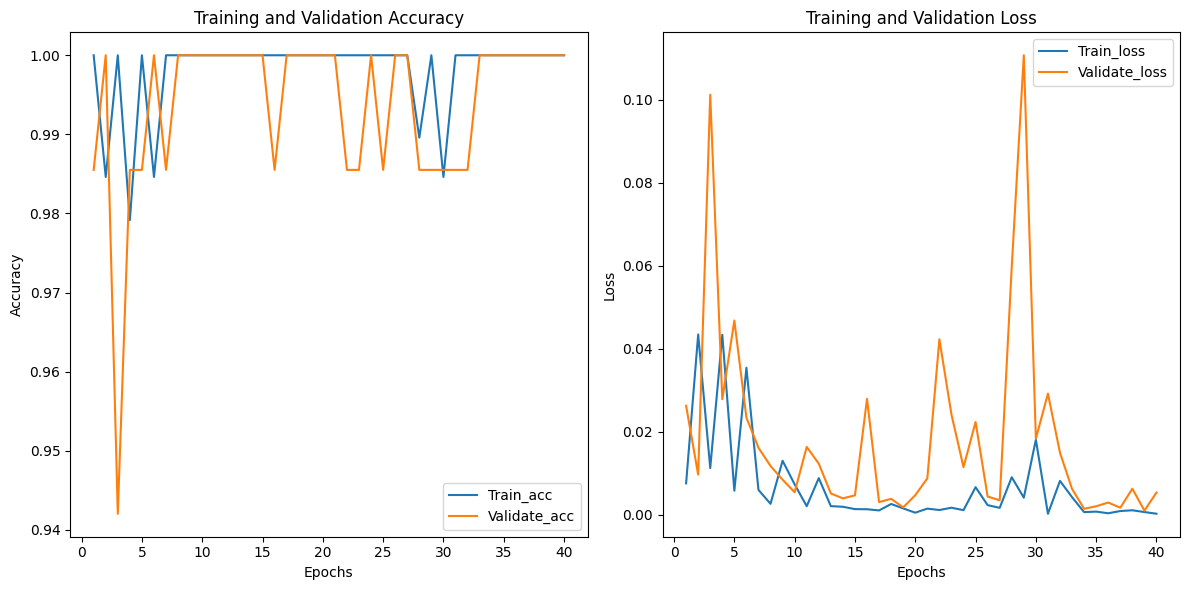

In [9]:
#View Accuracy (Training, Validation)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="Train_acc")
plt.plot(epochs, history.history["val_accuracy"], label="Validate_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

#View Loss (Training, Validation)
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label="Train_loss")
plt.plot(epochs, history.history['val_loss'], label="Validate_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
#Initial test generator
testPath = './Test/'
test_generator = datagen.flow_from_directory(
    testPath,
    class_mode="categorical",
    target_size=(224, 224),
    color_mode="rgb",
    shuffle=False,
    batch_size=1
)

#Get class id for y_real_class
y_true = test_generator.classes

#Predict images according to test_generator
preds = model.predict_generator(test_generator)
# print(preds.shape)
print(preds)

#Get predicted class labels (argmax along axis 1)
y_pred = np.argmax(preds, axis=1)
print(y_true)
print(y_pred)

#Calculate confusion matrix and classification report
confusion = confusion_matrix(y_true, y_pred)
classification_rep = classification_report(y_true, y_pred)

print("Confusion Matrix:")
print(confusion)
print("\nClassification Report:")
print(classification_rep)
y_pred = np.argmax(preds,axis=1)
print(test_generator.classes)
print(y_pred)

#Calculate confusion matrix, classification report between y_true and df_class
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Found 15 images belonging to 3 classes.


C:\Users\dream\AppData\Local\Temp\ipykernel_12724\1641310255.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator)


[[9.6107513e-01 3.4988452e-02 3.9363606e-03]
 [9.9541229e-01 1.7648579e-03 2.8228478e-03]
 [9.7561616e-01 2.3436144e-02 9.4778347e-04]
 [5.4140079e-01 1.0660007e-01 3.5199919e-01]
 [1.9840421e-03 9.9769574e-01 3.2015596e-04]
 [2.1094419e-02 9.5099425e-01 2.7911358e-02]
 [4.5882702e-02 9.3192816e-01 2.2189075e-02]
 [7.0354092e-01 2.9138616e-01 5.0729900e-03]
 [9.1370508e-05 9.9971575e-01 1.9285742e-04]
 [1.0831992e-03 9.9810648e-01 8.1031799e-04]
 [1.3558842e-04 1.7848148e-05 9.9984658e-01]
 [1.4933262e-03 1.5035823e-03 9.9700314e-01]
 [8.1211766e-03 4.3452200e-03 9.8753357e-01]
 [7.9791201e-03 1.3915639e-03 9.9062926e-01]
 [7.8103358e-06 1.5372103e-03 9.9845493e-01]]
[0 0 0 0 1 1 1 1 1 1 2 2 2 2 2]
[0 0 0 0 1 1 1 0 1 1 2 2 2 2 2]
Confusion Matrix:
[[4 0 0]
 [1 5 0]
 [0 0 5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      0.83      0.91         6
           2       1.00    